In [1]:
import json
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

import add_path
import toolkit.allen_helpers.stimuli as st
import toolkit.analysis.spectrum as spec
import toolkit.plots.plots as plots
import toolkit.pipeline.signal as ps
import toolkit.pipeline.location as pl
from toolkit.pipeline.data_io import SessionDirectory
from toolkit.pipeline.global_settings import GLOBAL_SETTINGS
from toolkit.utils.quantity_units import as_quantity, as_string

pd.set_option('display.max_columns', None)

with open('config.json') as f:
    config = json.load(f)

In [2]:
compute_psd = False

## Get session and load data

In [3]:
session_id = config['session_id']
ecephys_structure_acronym = config['ecephys_structure_acronym']
print(f"Session ID: {session_id}")

Session ID: 721123822


In [4]:
session_dir = SessionDirectory(session_id, ecephys_structure_acronym, cache_lfp=True)

probe_info = session_dir.load_probe_info()
if not session_dir.has_lfp_data:
    raise ValueError(f"Session {session_id} has no LFP data")

session = session_dir.session

c:\Users\ziaochen\.conda\envs\allen\lib\site-packages\hdmf\spec\namespace.py:590: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [5]:
stimulus_presentations = session.stimulus_presentations
session_type = session.session_type

stimulus_names = st.STIMULUS_NAMES[session_type]
drifting_gratings_stimuli = st.STIMULUS_CATEGORIES[session_type]['drifting_gratings']

In [6]:
central_channels = probe_info['central_channels']
layers = np.array(list(central_channels))[pl.argsort_channels(
    central_channels.values(), session_dir.load_lfp_channels())]

## Analyze data

### Process PSD

In [7]:
group_width = 1  # Number of channels to the left and right of the central channel
psd_tseg = 0.5  # segment duration in seconds
df = 1.0  # frequency resolution in Hz

In [8]:
if compute_psd:
    lfp_groups, channel_groups = ps.get_lfp_channel_groups(session_dir,
        central_channels, probe_id=probe_info['probe_id'], width=group_width)

    psd_das = {}
    cond_psd_das = {}

    for stim in stimulus_names:
        stim_trials = st.get_stimulus_trials(stimulus_presentations, stimulus_name=stim)
        aligned_lfp = st.align_trials(lfp_groups, stim_trials, window=(0., stim_trials.duration))
        psd_trials = ps.trial_psd(aligned_lfp, tseg=psd_tseg, df=df)
        psd_avg = psd_trials.mean(dim='presentation_id', keep_attrs=True)
        psd_das[stim] = psd_avg

        if stim in drifting_gratings_stimuli:  # has conditions
            conditions = st.presentation_conditions(stim_trials.presentations)
            cond_psd = st.average_across_conditions(psd_trials, *conditions)
            cond_psd_das[stim] = cond_psd

#### Save data

In [9]:
if compute_psd:
    # Save PSD of stimuli
    session_dir.save_psd(psd_das, channel_groups)

    # Save conditions PSD of drifting gratings
    session_dir.save_conditions_psd(cond_psd_das)
else:
    # Load PSD of stimuli
    psd_das = session_dir.load_psd()
    cond_psd_das = session_dir.load_conditions_psd()

### FOOOF Analysis

In [10]:
plt_range = 100.  # PSD frequency range for plotting

fooof_params = dict(
    freq_range=[200.],
    aperiodic_mode='knee',
    peak_width_limits=(0., np.inf),
    max_n_peaks=10,
    dB_threshold=0.8,
    peak_threshold=1.
)

freq_band_kwargs = dict(top_n_peaks=2, bandwidth_n_sigma=1.5)

wave_band_limit = GLOBAL_SETTINGS['wave_band_limit']
wave_band_limit = xr.DataArray(list(wave_band_limit.values()),
    coords=dict(wave_band=list(wave_band_limit), bound=['lower', 'upper']))
wave_band_width_limit = wave_band_limit.copy(
    data=list(GLOBAL_SETTINGS['wave_band_width_limit'].values()))

#### Fit FOOOF and get frequency bands

In [11]:
fooof_objs = {}
bands = np.full((len(stimulus_names), layers.size, wave_band_limit.wave_band.size, 2), np.nan)
peaks = np.full(bands.shape[:-1] + (freq_band_kwargs['top_n_peaks'], ), np.nan)

for i, stim in enumerate(stimulus_names):
    psd_avg = psd_das[stim]
    fooof_objs[stim] = {}
    for j, layer in enumerate(layers):
        psd_da = psd_avg.sel(layer=layer)

        # fit fooof
        fooof_result, fooof_objs[stim][layer], fooof_kwargs = spec.fit_fooof(psd_da, **fooof_params)
        gaussian_params = fooof_result.gaussian_params

        # get frequency bands
        for k, wave_band in enumerate(wave_band_limit.wave_band):
            band, peak_inds = spec.get_fooof_freq_band(
                gaussian_params=gaussian_params,
                freq_range=wave_band_limit.sel(wave_band=wave_band).values,
                width_limit=wave_band_width_limit.sel(wave_band=wave_band).values,
                **freq_band_kwargs
            )

            bands[i, j, k] = band
            peaks[i, j, k, :peak_inds.size] = gaussian_params[peak_inds, 1]

coords = dict(stimulus=stimulus_names, layer=layers, wave_band=wave_band_limit.coords['wave_band'])
bands = xr.DataArray(data=bands, coords=coords | dict(bound=wave_band_limit.coords['bound']))
peaks = xr.DataArray(data=peaks, coords=coords | dict(peak_rank=range(peaks.shape[-1])))

bands_ds = xr.Dataset(dict(
    bands=bands, peaks=peaks,
    wave_band_limit=wave_band_limit,
    wave_band_width_limit=wave_band_width_limit
))
bands_ds.attrs.update(fooof_kwargs | fooof_params | freq_band_kwargs)

#### Get band power in drifting grating conditions

In [12]:
condition_wave_band = 'beta'
fixed_condition_types = st.FIXED_CONDITION_TYPES[session_type]

cond_band_power_das = {}

for stim in drifting_gratings_stimuli:
    cond_band_power = {}
    for layer in layers:
        band = bands.sel(stimulus=stim, layer=layer, wave_band=condition_wave_band)
        if np.isnan(band).any():
            continue
        cond_psd = cond_psd_das[stim].sel(layer=layer)
        power = cond_psd.sel(frequency=slice(*band)).integrate('frequency').mean(dim=fixed_condition_types)
        unit = as_string(as_quantity(cond_psd.attrs['unit']) * as_quantity('Hz'))
        power.attrs.update(cond_psd.attrs | dict(unit=unit))
        cond_band_power[layer] = power

    if cond_band_power:
        cond_band_power_das[stim] = xr.concat(cond_band_power.values(),
            dim=pd.Index(cond_band_power, name='layer'), combine_attrs='override')
    else:
        print(f"No layer has detected {condition_wave_band} band during {stim}.")
        continue

#### Save data

In [13]:
# Save bands
session_dir.save_wave_bands(bands_ds)

# Save band power in drifting grating conditions
session_dir.save_condition_band_power(cond_band_power_das)

## Visualize PSDs

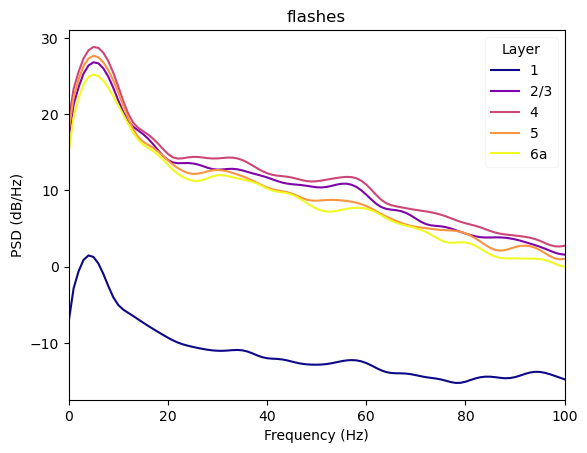

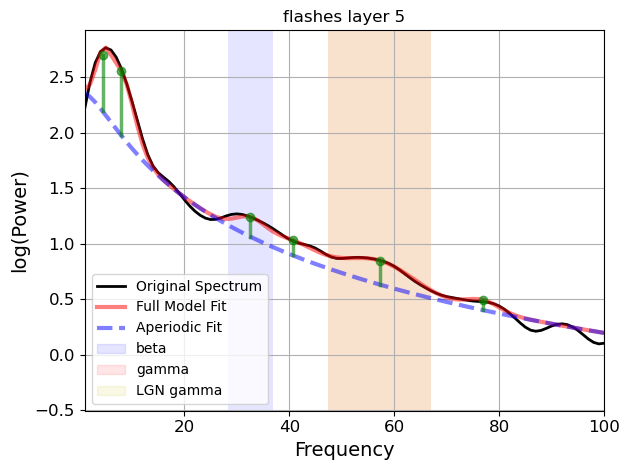

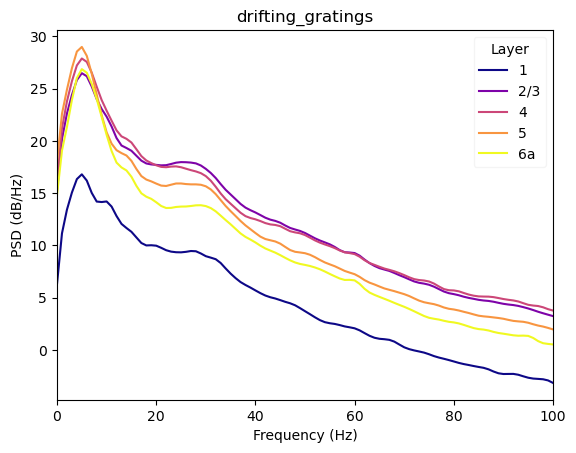

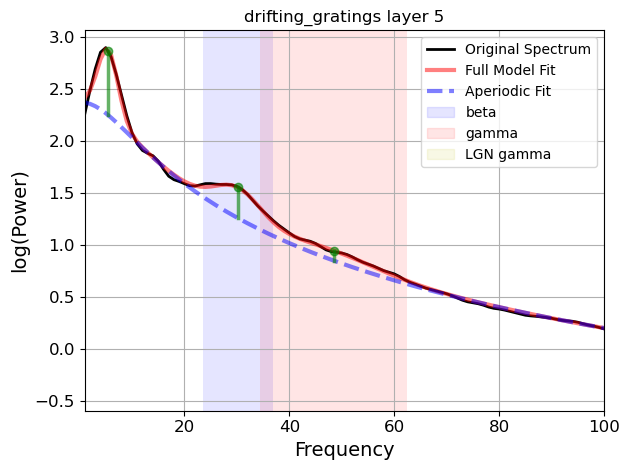

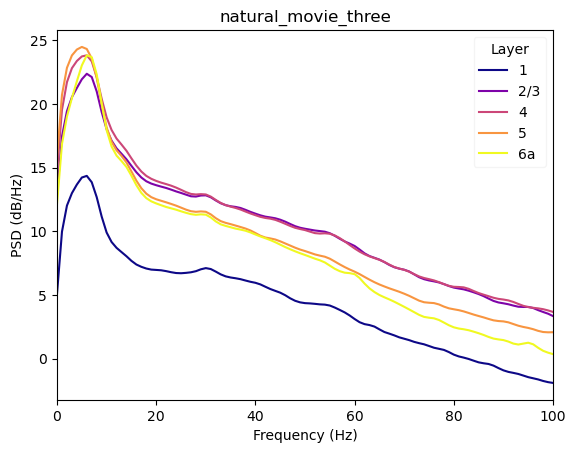

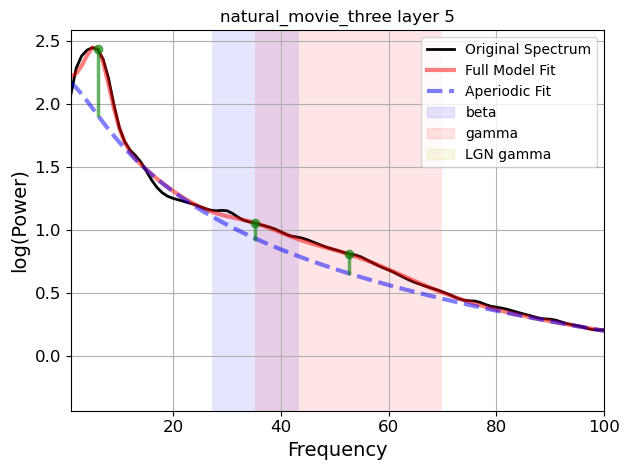

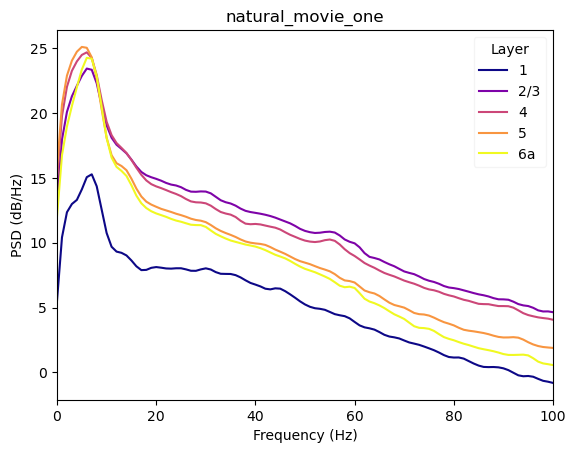

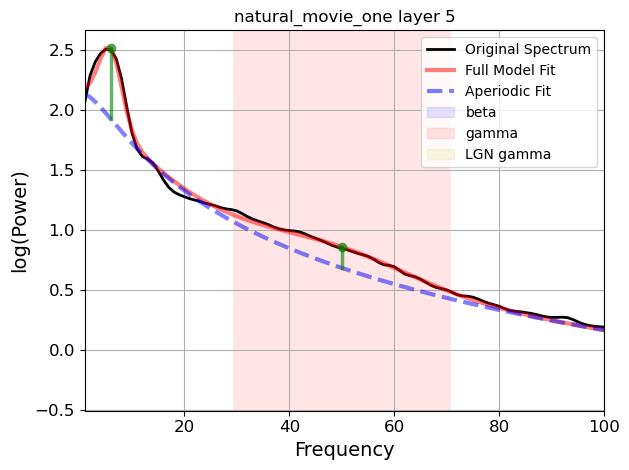

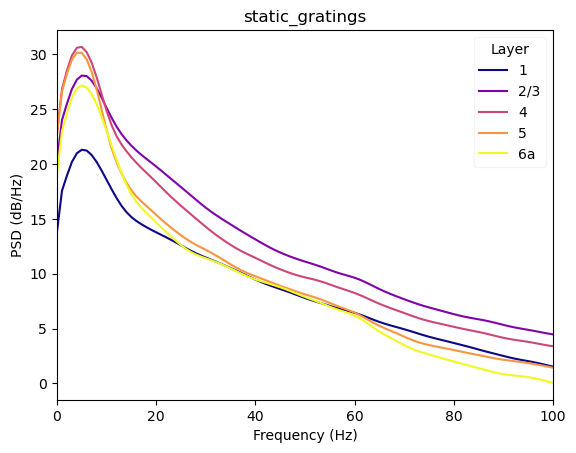

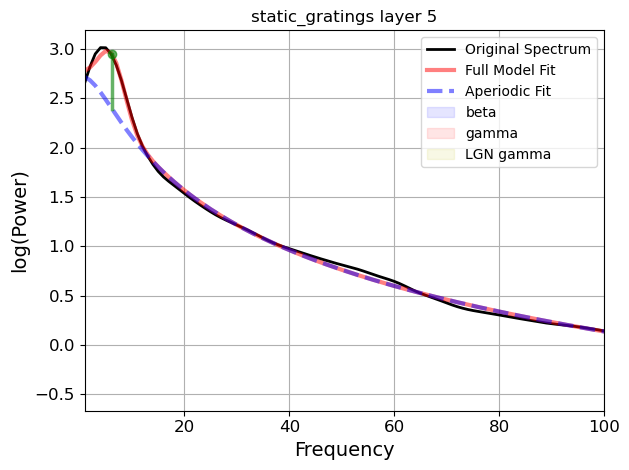

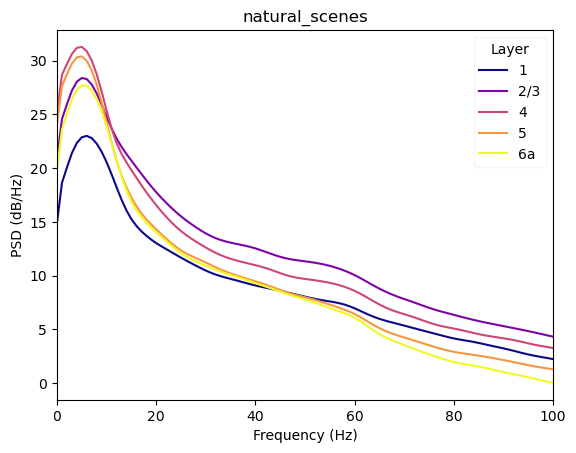

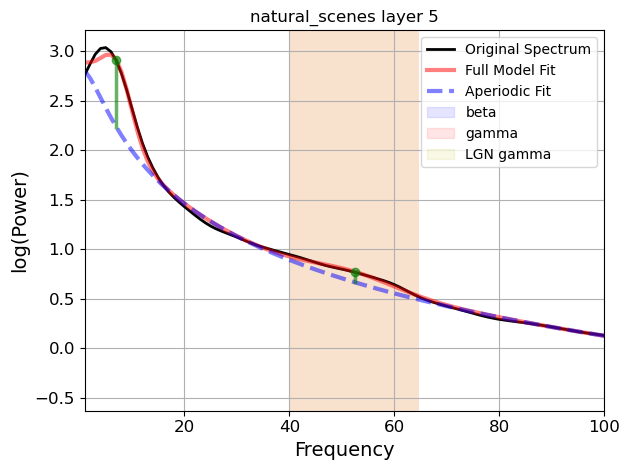

In [14]:
plt_layer = '5'

if plt_layer not in layers:
    raise ValueError(f"Layer {plt_layer} not found in LFP channels")

for stim in stimulus_names:
    psd_avg = psd_das[stim]
    ax = plots.plot_channel_psd(psd_avg, channel_dim='layer', freq_range=plt_range)
    ax.set_title(stim)

    _, ax = plt.subplots(1, 1)
    ax = plots.plot_fooof_quick(fooof_objs[stim][plt_layer], freq_range=plt_range, ax=ax)

    band = bands.sel(stimulus=stim, layer=plt_layer)
    ax = plots.plot_freq_band(band, band.wave_band, ax=ax)
    ax.set_title(f"{stim} layer {plt_layer}")

    plt.show()

drifting_gratings


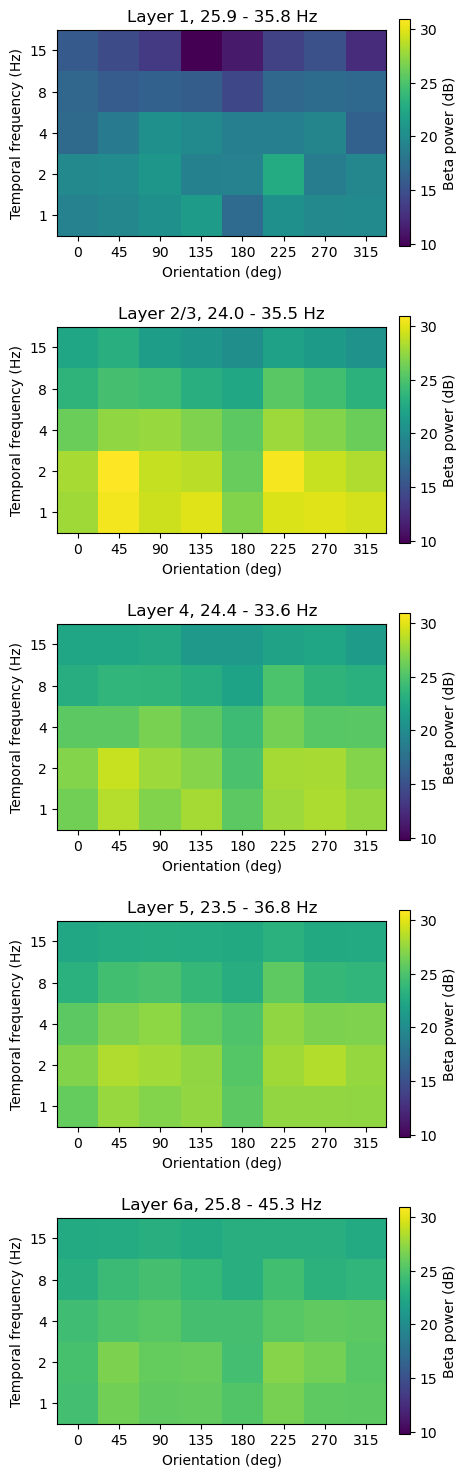

In [15]:
x_cond, y_cond = st.VARIED_CONDITION_TYPES[session_type]
cond_label = st.COND_LABEL

for stim, cond_band_power in cond_band_power_das.items():
    print(stim)
    cond_power_db = 10 * np.log10(cond_band_power)
    vmin, vmax = cond_power_db.min(), cond_power_db.max()
    layers_ = cond_power_db.layer.values
    _, axs = plt.subplots(layers_.size, 1, squeeze=False, figsize=(4.8, 3.0 * layers_.size))
    for layer, ax in zip(layers_, axs.ravel()):
        cpower = cond_power_db.sel(layer=layer).transpose(y_cond, x_cond)
        label = condition_wave_band.title() + ' power (dB)'
        band = bands.sel(stimulus=stim, layer=layer, wave_band=condition_wave_band).values

        x = cpower.coords[x_cond].values
        y = cpower.coords[y_cond].values
        cpower = cpower.assign_coords({x_cond: range(x.size), y_cond: range(y.size)})

        im = ax.imshow(cpower, origin='lower', vmin=vmin, vmax=vmax)
        cbar = plt.colorbar(im, ax=ax, label=label, pad=0.03)
        ax.set_xticks(cpower.coords[x_cond], labels=map('{:g}'.format, x))
        ax.set_yticks(cpower.coords[y_cond], labels=map('{:g}'.format, y))
        ax.set_xlabel(cond_label[x_cond])
        ax.set_ylabel(cond_label[y_cond])
        ax.set_title(f'Layer {layer}, {band[0]:.1f} - {band[1]:.1f} Hz')
    plt.tight_layout()
    plt.show()